In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# 2. Cargar y explorar el dataset

In [2]:
# Cargar archivo CSV
df = pd.read_csv('spam.csv', encoding='latin-1')  # Ajusta el encoding si es necesario
df = df[['v1', 'v2']]  # Asegúrate que las columnas se llamen así (v1: label, v2: texto)
df.columns = ['label', 'text']

print(df.head())
print(df['label'].value_counts())


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


# 3. preprocesamiento

In [3]:
# Codificar etiquetas
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # spam = 1, ham = 0

# Vectorizar texto
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# 6. definimos el modelo que usaremos MLP

In [4]:
class SpamMLP(nn.Module):
    def __init__(self, input_dim):
        super(SpamMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

model = SpamMLP(input_dim=X_train.shape[1])
model.to(device)


SpamMLP(
  (net): Sequential(
    (0): Linear(in_features=3000, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

# entrenamiento

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
batch_size = 64

losses = []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices].view(-1, 1)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.0999
Epoch 2/10, Loss: 0.0223
Epoch 3/10, Loss: 0.0026
Epoch 4/10, Loss: 0.0009
Epoch 5/10, Loss: 0.0825
Epoch 6/10, Loss: 0.0010
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0005
Epoch 9/10, Loss: 0.0012
Epoch 10/10, Loss: 0.0013


# evaluacion

In [6]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds = (preds > 0.5).float().cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, preds))
print(classification_report(y_true, preds))

Accuracy: 0.979372197309417
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       965
         1.0       0.96      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



# visualizacion de perdida

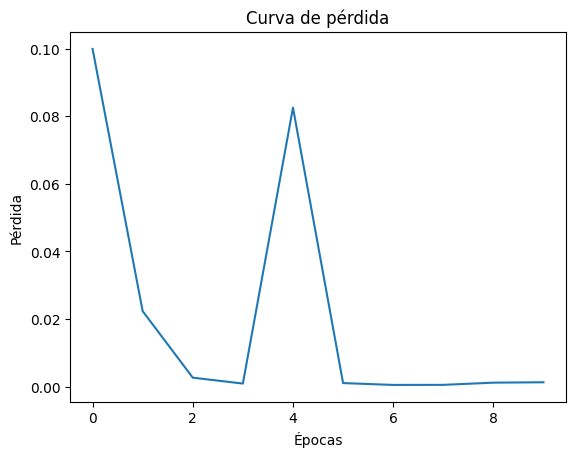

In [7]:
plt.plot(losses)
plt.title("Curva de pérdida")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()
